In [2]:
import os, sys
import matplotlib.pyplot as plt

parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)

from src.ml.object_detector import ObjectDetectModel

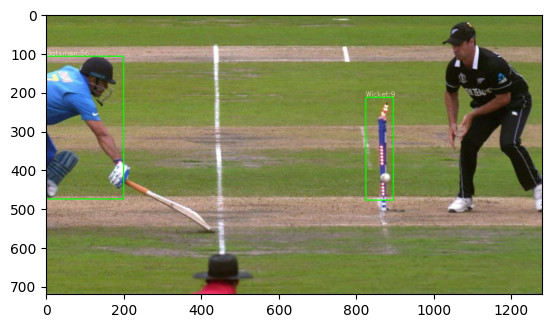

In [3]:
object_detect_model_path = "../../training-jobs/detect/cricket-object-detect17/weights/best.onnx"
# img_path = "../data/Cricket-Semantic-Segmentation[Native]/images/2022-08-24 (13).png"
img_path = "../data/test/ms-dhoni-run-out-in-2019-wc-semi-finals.jpg"

model = ObjectDetectModel(object_detect_model_path)
output = model(img_path)
output.show_image()

In [4]:
batsman_box = output.getBoxFromLabel("Batsmen")
wicket_bbx = output.getBoxFromLabel("Wicket")

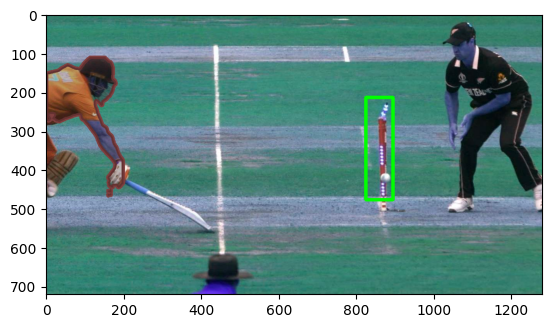

In [5]:
from src.ml.yolo_image_segmentor import ImageSegmentModel
image_segment_model_path = "../../model-weights/yolov8_batsmen_image_segment.onnx"
# Initialize YOLOv8 Instance Segmentator
segmentor = ImageSegmentModel(image_segment_model_path, conf_thres=0.3, iou_thres=0.5)

img_path = "../data/test/ms-dhoni-run-out-in-2019-wc-semi-finals.jpg"

# Detect Objects
batsman_seg = segmentor(img_path, batsman_box)

import cv2 as cv
from src.data.visualize import drawSegments, drawRects
img = cv.imread(img_path)
drawn_img = drawSegments(img, [[0, *batsman_seg]])
drawn_img = drawRects(drawn_img, [[1, *wicket_bbx]], False)
plt.imshow(drawn_img)
plt.show()

In [7]:
from src.ml.crease_cross_detector import CreaseCrossDetector
cross_detector = CreaseCrossDetector()
cross_detector(img_path, batsman_seg, wicket_bbx)

False

In [1]:
import os, sys
import matplotlib.pyplot as plt
import cv2 as cv
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)
from src.ml.pipeline import Pipeline
from src.data.visualize import drawRects

test_imgs_path = "../data/test"
img_nms = os.listdir(test_imgs_path)
img_nms = [nm for nm in img_nms if os.path.splitext(nm)[1] in (".png", ".jpg", ".jpeg")]
img_id = 19
# img_path = "../data/test/2022-08-24 (13).png"
# img_path = "../data/test/Runout-scenario-in-a-cricket-match.jpg"
# img_path = "../data/test/Runout-scenario-in-a-cricket-match.jpg"
# img_path = "../data/test/ms-dhoni-run-out-in-2019-wc-semi-finals.jpg"
img_path = f"{test_imgs_path}/{img_nms[img_id]}"

object_detect_model_path = "../../training-jobs/detect/cricket-object-detect17/weights/best.onnx"
image_segment_model_path = "../../model-weights/yolov8_batsmen_image_segment.onnx"
classifer_model_path = "../../model-weights/yolov8_batsmen_image_segment.onnx"
batsman_analysis_img_path = "temp/batsman-anaylsis.jpg"
wicket_img_path = "temp/wicket.jpg"


pipe = Pipeline(object_detect_model_path, image_segment_model_path,classifer_model_path)
res = pipe(img_path, batsman_analysis_img_path,wicket_img_path)


In [2]:
print(res)

{
  "annotations": [
    [
      "Batsman",
      0,
      11,
      74,
      106
    ],
    [
      "Wicket",
      254,
      58,
      260,
      90
    ]
  ],
  "batsman_result": "False",
  "batsman_analysis_img_path": "temp/batsman-anaylsis.jpg",
  "wicket_result": "True",
  "wicket_img_path": "temp/wicket.jpg"
}


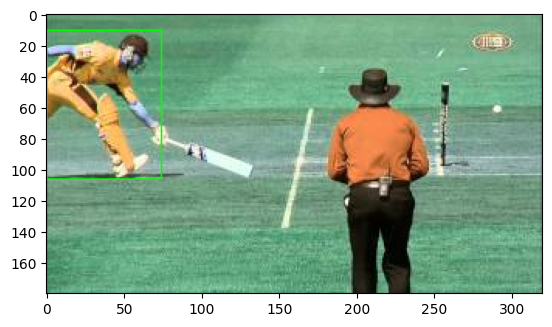

In [7]:
img = cv.imread(img_path)
drawn_img = drawRects(img, [[
      "Batsman",
      0.,         0.06111111, 0.23125,    0.5888889
    ]], False)
plt.imshow(drawn_img)
plt.show()

In [3]:
from src.util.file import OutputProcessor
import boto3

s3_client = boto3.client("s3")
op = OutputProcessor(s3_client, "third-umpire-decision-automation-osura")
op(res)

{'annotations': [['Batsman', 0, 11, 74, 106], ['Wicket', 254, 58, 260, 90]],
 'batsman_comment': 'False',
 'batsman_analysis_img_s3_uri': 's3://third-umpire-decision-automation-osura/results/fea6b6b2-3fa7-443d-bec0-69c2e1c47c1b/batsman-analysis-img.jpg',
 'wicket_s3_uri': 's3://third-umpire-decision-automation-osura/results/fea6b6b2-3fa7-443d-bec0-69c2e1c47c1b/wicket-croped-img.jpg',
 'wicket_comment': 'True',
 'job_id': 'fea6b6b2-3fa7-443d-bec0-69c2e1c47c1b'}